# 1. Data Collecting

---
**Intro to Data Science - Final Project**
- **Team members**:
    - Nguyễn Duy Đăng Khoa - 21127078
    - Nguyễn Ngọc Vũ - 21127483
    - Phạm Nguyễn Quốc Thanh - 21127428
    - Nguyễn Vinh Quang - 20127606
- **Intructor**:
    - Mr. Nguyễn Bảo Long
---

- Our team's topic is about movies and their ratings.
- We've collected from **2 sources**, each requiring their own execution:
    A. Rotten Tomatoes (https://www.rottentomatoes.com/)
    B. IMDB (https://www.imdb.com/)

## A. Collect data (Rotten Tomatoes)

#### Import libraries in use:
- requests: send HTTP requests
- bs4: parsing HTML elements
- Selenium: helps render and retrieve JavaScript content

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

#### Collect movie links to crawl data
We get the movie links based on movie genres, we will crawl the data on these links later

In [3]:
links = []
search_params = ['action','adventure','animation','anime','biography','comedy', 'crime', 'documentary', 'drama', 'entertainment',
                 'faith_and_spirituality', 'fantasy', 'game_show', 'history', 'holiday', 'horror', 'kids_and_family', 'music', 
                 'musical', 'mystery_and_thriller', 'reality', 'romance', 'sci_fi', 'sports', 'western', 'war']
# get links for movies
for search in search_params:
    response = requests.get(f"https://www.rottentomatoes.com/browse/movies_at_home/genres:{search}?page=8")
    soup = BeautifulSoup(response.content, 'html.parser')
    link_elements = soup.select('div > tile-dynamic > a')
    for element in link_elements:
        links.append(element['href'])

links = list(set(links))#remove duplicated links
print(len(links))

1205


Remove links from links list that are already in the previous crawled data file

In [4]:
df = pd.read_csv('../../data/raw/data.csv')
#remove crawled links
for url in links[:]:
    if (f"https://www.rottentomatoes.com{url}") in df['url'].values:
        links.remove(url)

#### Collect data from movie links
First, We build a function to get the HTML text/data

In [5]:
def get_element_text(soup, selector):
    element = soup.select_one(selector)
    text =''
    if element:
        text = element.get_text()
        text = text.split()
        text = ' '.join(text)
    else:
        text = ''
    return text

Initial field lists for Dataframe

In [6]:
#init lists to store values for attributes
Name = []
Genre = []
Tomatometer_score = []
Tomatometer_count = []
Audience_score = []
Audience_count = []
Runtime = []
Classification_rating = []
Release_year = []
Original_language = []
Urls = []

We use BeautifulSoup to help retrieve and parse the HTML content. But since the selector of BeautifulSoup doesn't work for some data fields like TomatometerRate and AudienceRate because they're inside shadow-root and the shadow-root object isn't visible in the document root, so we build a method that takes a list of ShadowDom root locators and use Selenium to help execute JavaScript and retrieve the shadow element. So we build a function to retrieve shadow element from it's parent:

In [7]:
#find shadow element from shadow root
def expand_shadow_element(element):
  shadow_root = driver.execute_script('return arguments[0].shadowRoot', element)
  return shadow_root

Crawl data from the movie links: set a number of movies we want to collect for each run and get the HTML text for data field

In [8]:
count = 0        
#crawl data movies
for url in links:
    response = requests.get(f"https://www.rottentomatoes.com{url}")
    soup = BeautifulSoup(response.content, 'html.parser')
    #name
    name = get_element_text(soup, '#scoreboard > h1')
    Name.append(name)

    #tomatometer rate and audience rate (these two have to be crawled seperatedly since they're inside Shadow DOM object)
    driver = webdriver.Chrome()
    driver.get(f"https://www.rottentomatoes.com{url}")
    root1 = driver.find_element(By.CSS_SELECTOR, "#scoreboard")
    shadow_root1 = expand_shadow_element(root1)
    root2a = shadow_root1.find_element(By.CSS_SELECTOR,'div > div.scores-container > div.tomatometer-container > div > score-icon-critic-deprecated')
    shadow_root2a = expand_shadow_element(root2a)
    root2b = shadow_root1.find_element(By.CSS_SELECTOR,'div > div.scores-container > div.audience-container > div > score-icon-audience-deprecated')
    shadow_root2b = expand_shadow_element(root2b) 
    tomatometer_score = shadow_root2a.find_element(By.CSS_SELECTOR,'div > span.percentage').text
    audience_score = shadow_root2b.find_element(By.CSS_SELECTOR,'div > span.percentage').text
    driver.quit()
    Tomatometer_score.append(tomatometer_score)
    Audience_score.append(audience_score)

    #number of tomatometers
    tomatometer_count = get_element_text(soup, '#scoreboard > a:nth-child(3)')
    tomatometer_count = tomatometer_count.split(" ")[0]
    Tomatometer_count.append(tomatometer_count)

    #number of audiences
    audience_count = get_element_text(soup, '#scoreboard > a:nth-child(4)')
    audience_count = audience_count.split(" ")[0]
    Audience_count.append(audience_count)

    #runtime
    runtime = get_element_text(soup,'#scoreboard > p')
    runtime = runtime.split(", ")[-1]
    Runtime.append(runtime)

    #release
    year = get_element_text(soup,'#scoreboard > p')
    year = year.split(", ")[0]
    Release_year.append(year)
    
    #Get Classification, Genre and Original Language
    contents= ['','','']
    for i in range(5):
        temp = get_element_text(soup, f'#info > li:nth-child({i}) > p > b')
        content = get_element_text(soup, f'#info > li:nth-child({i}) > p > span')
        if(temp == 'Rating:'):
            #classification
            contents[0] = content
        if(temp == 'Genre:'):
            #genre
            contents[1] = content
        if(temp == 'Original Language:'):
            #language
            contents[2] = content
    Classification_rating.append(contents[0])
    Genre.append(contents[1])
    Original_language.append(contents[2])

    #link
    Urls.append("https://www.rottentomatoes.com" + url)
    
    count +=1
    #if(count % 1 == 0):
     #   print(count)
    if(count == 1): #set count limit for each crawling time
        break

#### Save collected data

In [9]:
data = pd.DataFrame({'name':Name,
                     'genre':Genre,
                     'tomatometer_score': Tomatometer_score,
                     'tomatometer_count':Tomatometer_count,
                     'audience_score': Audience_score,
                     'audience_count': Audience_count,
                     'classification':Classification_rating,
                     'runtime':Runtime, 
                     'release_year':Release_year,
                     'original_language':Original_language,
                     'url':Urls})

data.to_csv('../../data/raw/data.csv', mode='a', header=False,index=False)

In [10]:
df_copy = pd.read_csv('../../data/raw/data.csv')
df_copy = df_copy.drop_duplicates()

print(df_copy.shape)

(1216, 11)


## B. Collecting Data (IMDB)
- Retrieve data from the IMDB page: https://www.imdb.com/search/title/

### 1.1 Set-up Environment

In [ ]:
import requests
import json
import pandas as pd

### 1.2 Condition for sending a request and establishing variables to store data.

### How to get the api:

-Right-click on the website, select "inspect element."

-Go to the "network" section and click on "clear all."

-Choose the genres or types of movies or TV shows to find the necessary API.

-Search for an API that contains data about movies in the network section.

-Find another API to discover the patterns of APIs when changing genres or release years.

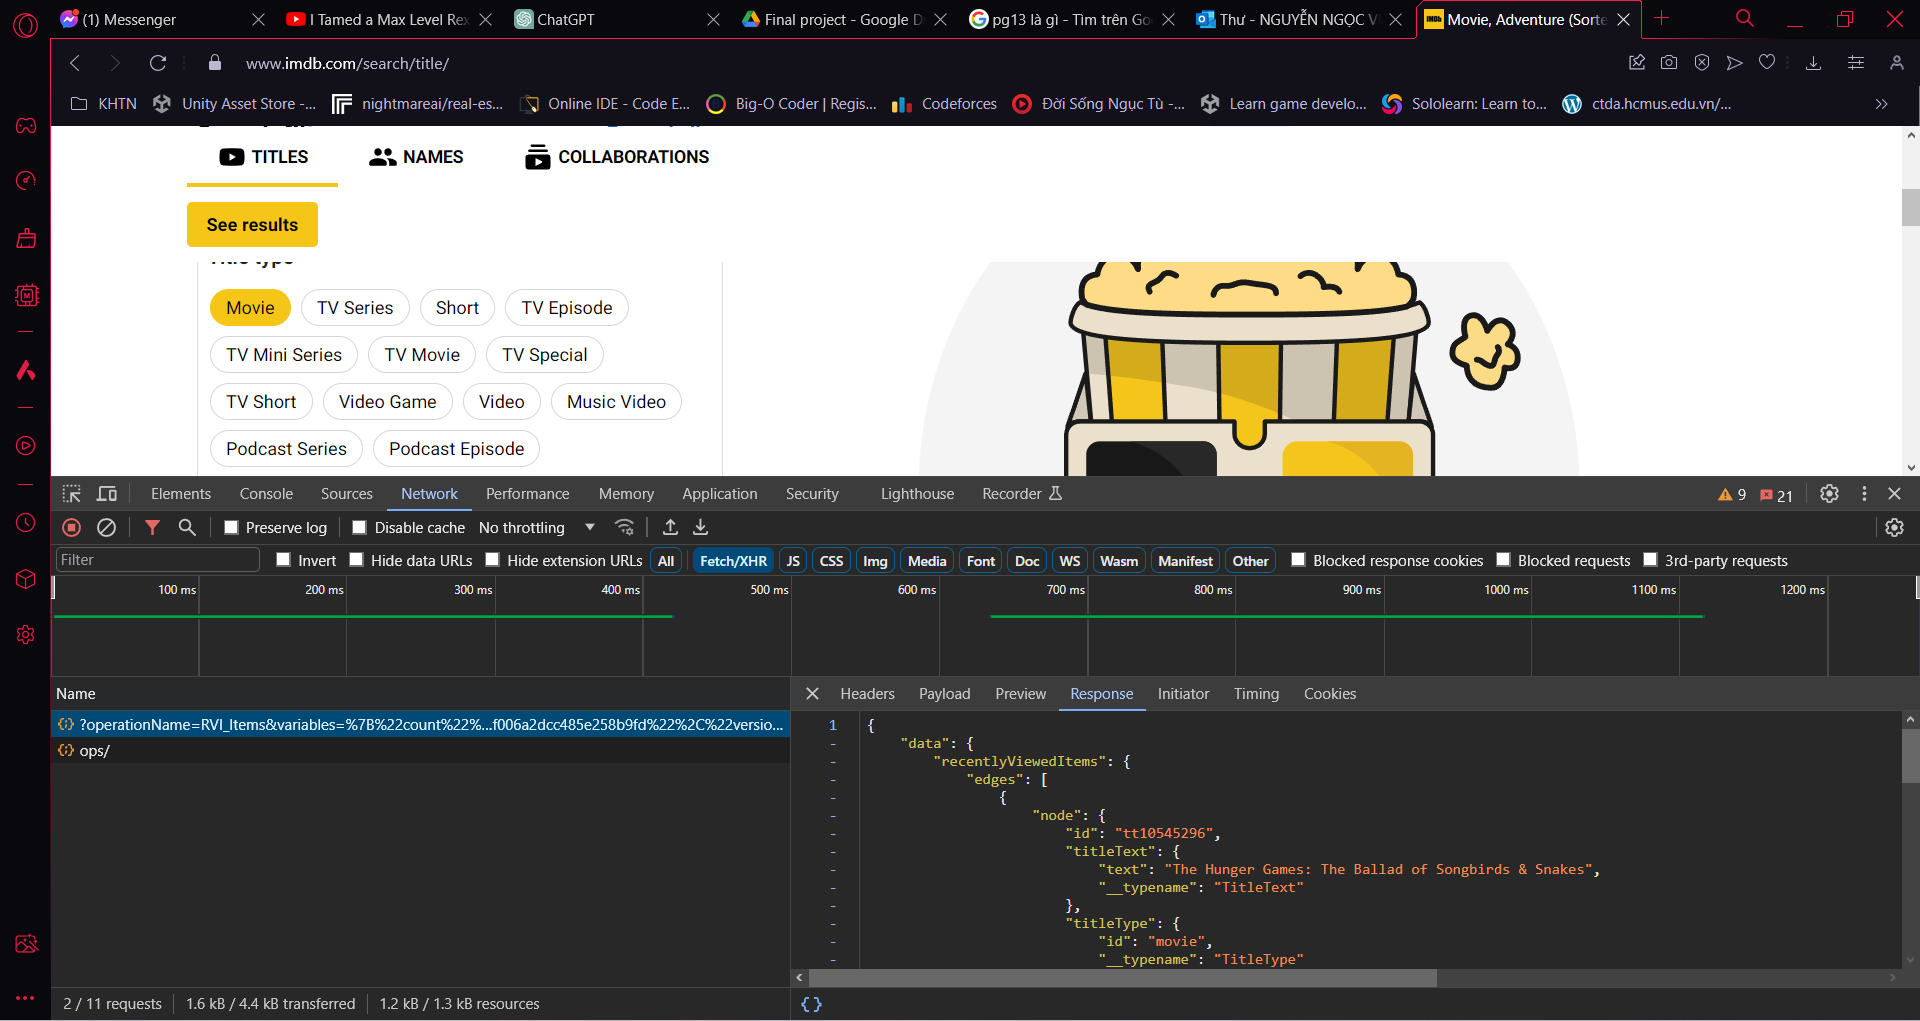

### TEXT COMPARE: Use to find the different between the two API.
-Put two API in and then press compare.

-The result shows that the variables is the only thing that change when changing release year,genre.
### Check the api with postman to see the params and headers

### POSTMAN: Postman is a popular collaboration platform for API development. It provides a user-friendly interface that allows developers to create, test, and manage APIs more efficiently.

-After identifying the patterns between two APIs, input one of the APIs into Postman to observe the values of its components.

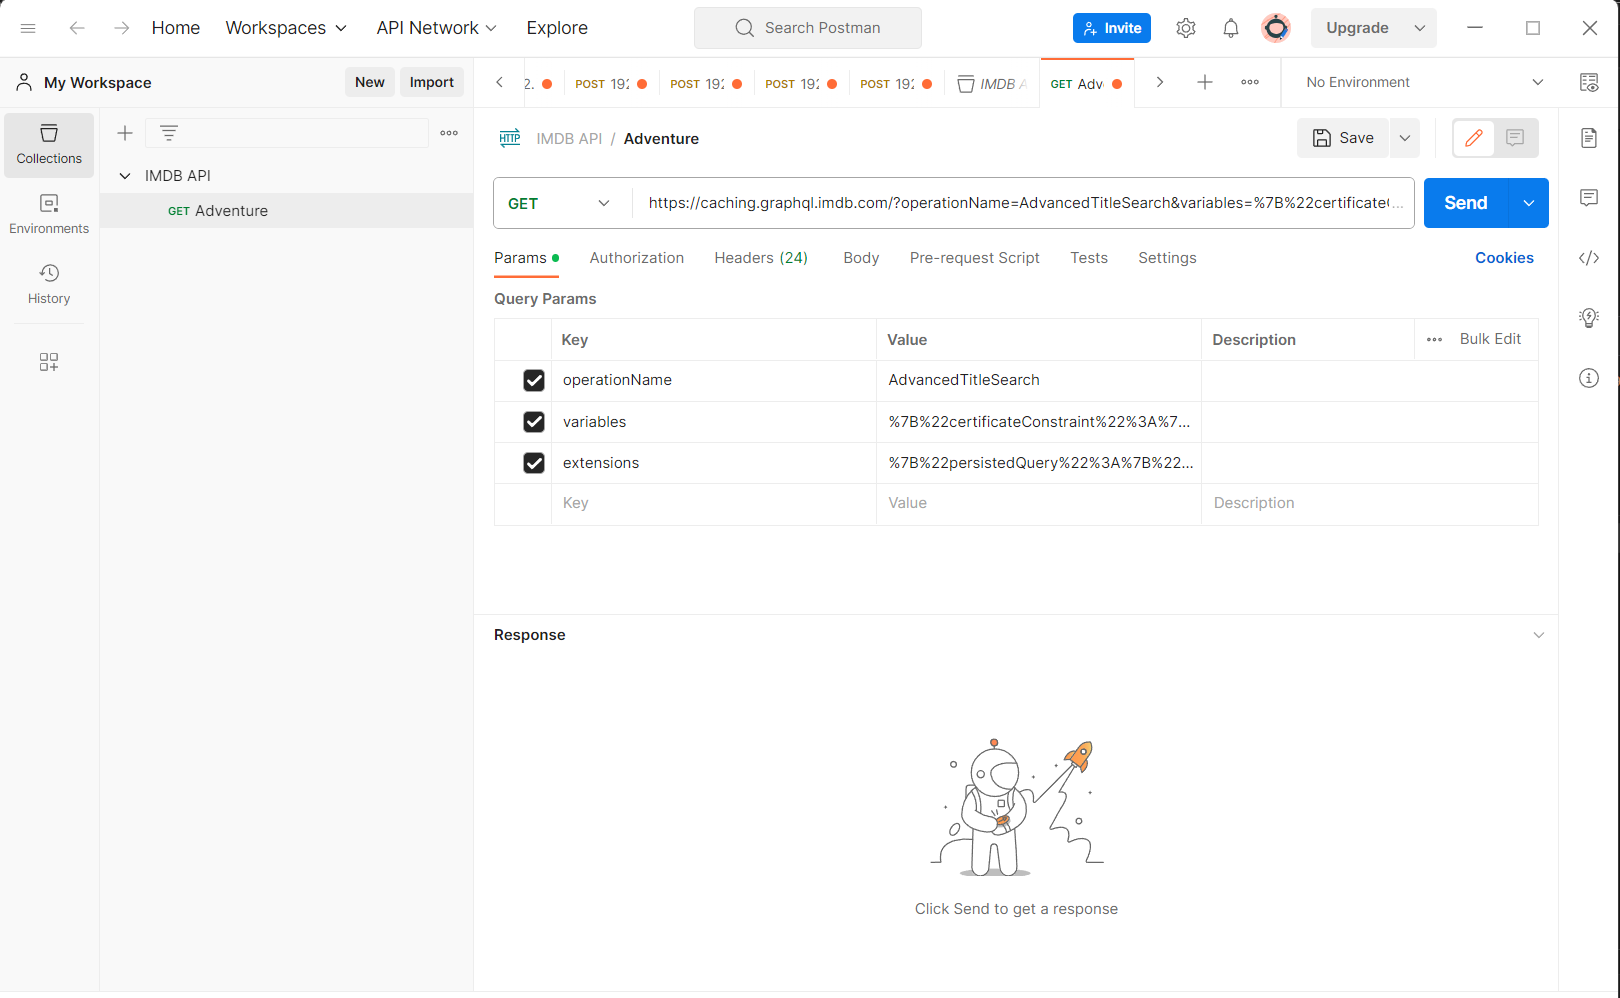

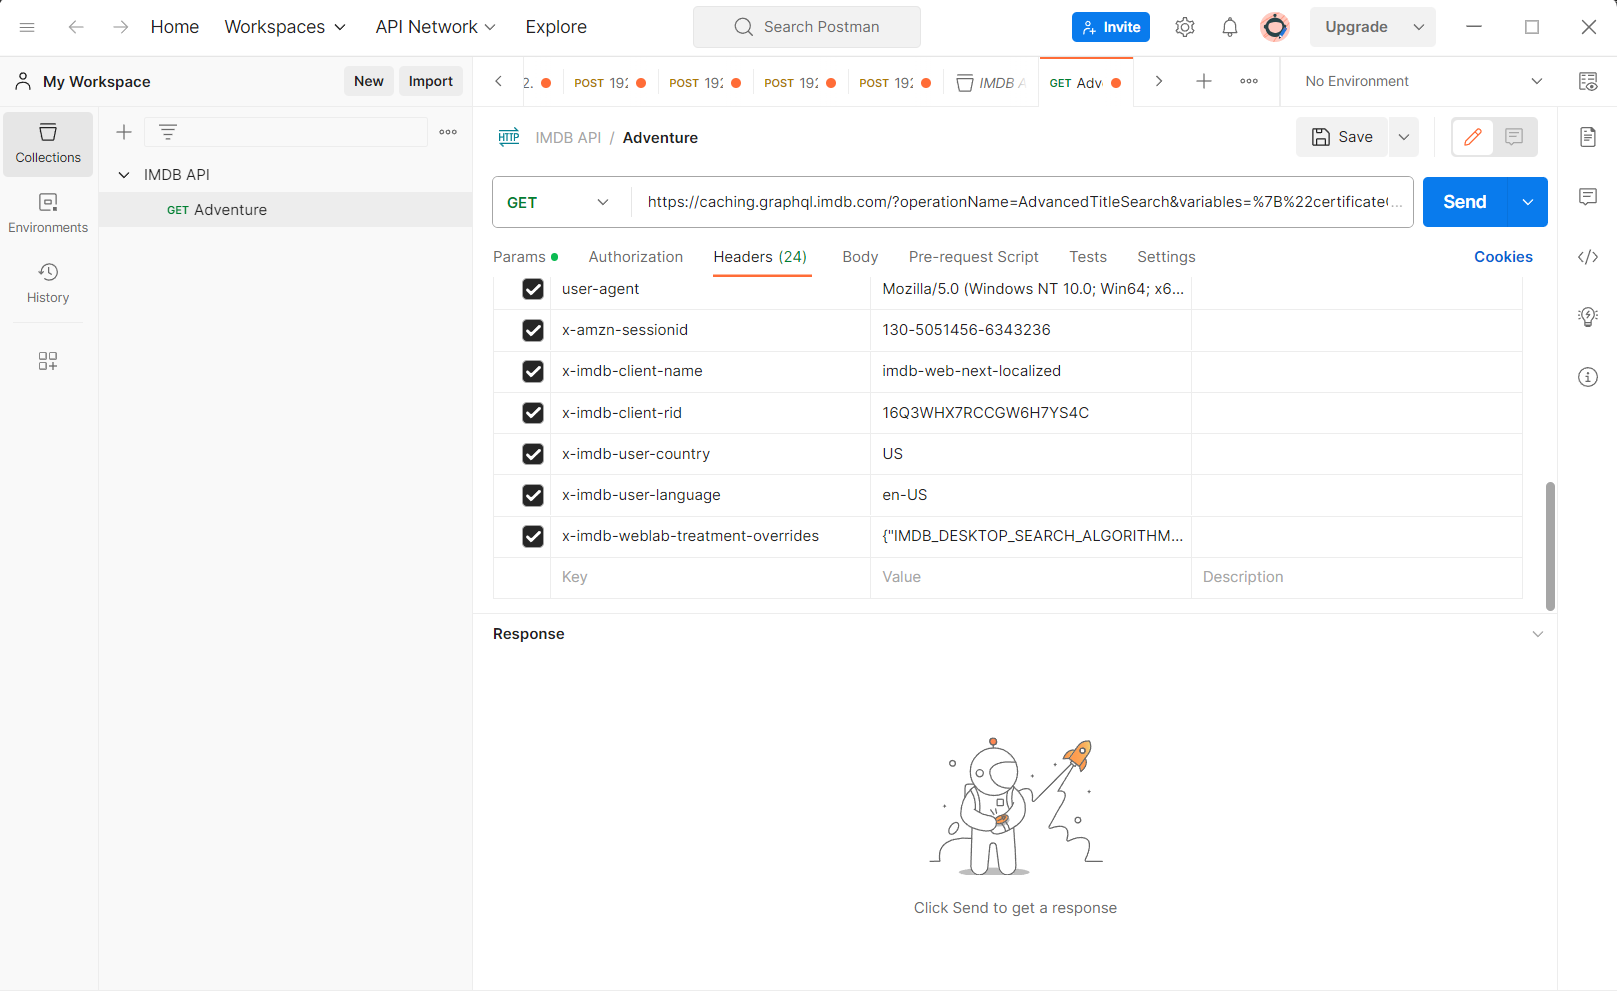

### Check the api for others genre for the rule between api changes
Only the variables change with the change of genre, release year  

-Send a request with headers and parameters similar to those sent by the web client to the server to ensure the proper communication as intended by the web developer.

In [ ]:
extensions = '%7B%22persistedQuery%22%3A%7B%22sha256Hash%22%3A%227327d144ec84b57c93f761affe0d0609b0d495f85e8e47fdc76291679850cfda%22%2C%22version%22%3A1%7D%7D'


url = 'https://caching.graphql.imdb.com/?operationName=AdvancedTitleSearch&variables={}&extensions={}'
# url = 'https://caching.graphql.imdb.com/'

headers = {
    "authority":"caching.graphql.imdb.com",
    "accept":"application/graphql+json, application/json",
    "accept-language":"en-US,en;q=0.9",
    "content-type":"application/json",
    "cookie":"uu=eyJpZCI6InV1ZjdkZDIxZTQxNjI2NDk5ZDlmMzQiLCJwcmVmZXJlbmNlcyI6eyJmaW5kX2luY2x1ZGVfYWR1bHQiOmZhbHNlfX0=; session-id=130-5051456-6343236; ubid-main=135-3141743-8299733; session-id-time=2082787201l; session-token=gCSbg4aEjMHkKMQozdNXcZ9pw5Bx1pDKZO/E/hxf99m9bObwEAHonk2ZLiMp+/1y9+pRdPmKxBz5OKrKF7h/kTuTduzH2HavA4pchVBWbVvefQHVOCICwLLzTplkJexUZWnijHssy5Rrr3vonX332+wJtjUll2E4RuXlAVpq6UMLDgDdi11TOX4Nc4FTmxJFDNXpXLF0VUii18SLtS37GHC5zKNnsv/3YWVevSV+jjDXuUV9nYtmwY7yCUhfqJI2nukbbbXygVPwbdGLRh3WQAJr9jOpGrN+2HV1IgwHrsxDuj4wF1NNiL0jjg+zuWKB7BVbGTVQuTLpQXHGLO4WHkYwZoBCZf0r; ad-oo=0",
    "origin":"https://www.imdb.com",
    "referer":"https://www.imdb.com/",
    "sec-fetch-dest":"empty",
    "sec-fetch-mode":"cors",
    "sec-fetch-site":"same-site",
    "user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.5993.118 Safari/537.36",
    "x-amzn-sessionid":"130-5051456-6343236",
    "x-imdb-client-name":"imdb-web-next-localized",
    "x-imdb-client-rid":"16Q3WHX7RCCGW6H7YS4C",
    "x-imdb-user-country":"US",
    "x-imdb-user-language":"en-US",
    "x-imdb-weblab-treatment-overrides":'{"IMDB_DESKTOP_SEARCH_ALGORITHM_UPDATES_577300":"T1"}',
}

full_data = {}
full_data.setdefault('Title', [])
full_data.setdefault('Genre',[])
full_data.setdefault('ReleaseYear',[])
full_data.setdefault('Rating',[])
full_data.setdefault('VoteCount',[])
full_data.setdefault('Duration',[])
full_data.setdefault('Age Limit',[])
year = range(2014, 2023)

### 1.3 Function
Parse_value: parse data from the json in data
generate_variable: because the variables change when changing genre or release year, so we need to create a new variables for every time we change genre or release year for various data


In [ ]:
def parse_value(data):
    #Name
    full_data['Title'].append(data['node']['title']['titleText']['text'])
    
    #Genres
    GenreList=[]
    for genre in data['node']['title']['titleGenres']['genres']:
        GenreList.append(genre['genre']['text'])
    full_data['Genre'].append(GenreList)
    
    #ReleaseYear
    full_data['ReleaseYear'].append(data['node']['title']['releaseYear']['year'])
    
    #Rating and RatingCount
    full_data['Rating'].append(data['node']['title']['ratingsSummary']['aggregateRating'])
    full_data['VoteCount'].append(data['node']['title']['ratingsSummary']['voteCount'])

    #Duration
    if data['node']['title']['runtime'] is not None:
        full_data['Duration'].append(data['node']['title']['runtime']['seconds']/3600)
    else: full_data['Duration'].append(None)
    
    #AgeLimit
    if data['node']['title']['certificate'] is not None:
        full_data['Age Limit'].append(data['node']['title']['certificate']['rating'])
    else : full_data['Age Limit'].append(None)
        
        
def generate_variable(genre, from_time, to_time):
    return json.dumps({"certificateConstraint":{},"colorationConstraint":{},"creditedCompanyConstraint":{},"first":50,"genreConstraint":{"allGenreIds":[genre]},"listConstraint":{"inAllLists":[],"inAllPredefinedLists":[],"notInAnyList":[],"notInAnyPredefinedList":[]},"locale":"en-US","releaseDateConstraint":{"releaseDateRange":{"end":f"{to_time}-01-01","start":f"{from_time}-01-01"}},"runtimeConstraint":{"runtimeRangeMinutes":{}},"sortBy":"POPULARITY","sortOrder":"ASC","titleTypeConstraint":{"anyTitleTypeIds":["movie"]},"userRatingsConstraint":{"aggregateRatingRange":{},"ratingsCountRange":{}}})

# def Filter_duplicate_data():
#     df = pd.DataFrame(full_data)
#     df.drop_duplicates(subset=["Title","ReleaseYear"])

In [ ]:
for from_time, to_time in zip(year[:-1], year[1:]):
    for genre in ['Action', 'Adventure', 'Animation','Comedy','Crime']:
        params = {
                    'operationName' : 'AdvancedTitleSearch',
                    'variables' : generate_variable(genre, from_time, to_time),
                    'extensions' : extensions
                    }
        data = requests.get(url=url.format(params['variables'],params['extensions']), headers=headers)
        # data = requests.get(url=url, params=params, headers=headers)
        a = data.json()
        for data in a['data']['advancedTitleSearch']['edges']:
            parse_value(data)

#Save collected data to CSV
full_data.to_csv('../../data/raw/data_imdb.csv',index=False)